<a href="https://colab.research.google.com/github/Aleksey55555/DAG_classification/blob/master/another_DAG_clf_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Эксперимент: Классификация с помощью SimpleDAGClassifier

В этом ноутбуке мы реализуем и обучbм простую модель **SimpleDAGClassifier** — мягкий аналог дерева решений (mixture of experts).  
Идея модели: входные признаки направляются в «гейтинг»-модуль, который вычисляет распределение по листьям.  
Каждый лист содержит многоклассовую логистическую регрессию, и итоговое предсказание — смесь распределений по листьям.



## Датасет

В качестве данных используется табличный датасет (train/test split).  
Каждый объект описывается набором признаков, целевая переменная — метка класса.  
Данные преобразованы в `torch.Tensor` для использования в PyTorch.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F


### Рассмотрим учебный датасет Iris и сравним классические моедли.

In [2]:

# ==== 1. Dataset ====
data = load_iris()
X, y = data.data, data.target
n_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# ==== 2. Baseline models ====
logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)

acc_logreg = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)

f1_logreg = f1_score(y_test, y_pred_log, average="macro")
f1_rf = f1_score(y_test, y_pred_rf, average="macro")


# ==== 3. Simplified DAG classifier (multiclass) ====
class SimpleDAGClassifier(nn.Module):
    def __init__(self, n_features, n_internal=8, n_leaves=6, n_classes=3):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)

        # В листьях многоклассовая логистическая регрессия
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)       # (B, n_internal)
        r = torch.matmul(h_int, self.int_to_leaf)      # (B, n_leaves)
        pi = F.softmax(r, dim=1)                       # (B, n_leaves)

        # линейная модель в каждом листе
        logits = torch.einsum("bd, lcd -> blc", x, self.leaf_theta) + self.leaf_bias  # (B, n_leaves, C)
        probs = F.softmax(logits, dim=-1)  # (B, n_leaves, C)

        # смешивание листьев
        y_hat = torch.einsum("bl, blc -> bc", pi, probs)  # (B, C)
        return y_hat


# ==== 4. Train DAG ====
torch.manual_seed(42)
model = SimpleDAGClassifier(n_features=X.shape[1], n_classes=n_classes)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

for epoch in range(200):
    model.train()
    opt.zero_grad()
    y_pred = model(X_train_t)
    loss = F.cross_entropy(y_pred, y_train_t)
    loss.backward()
    opt.step()

model.eval()
with torch.no_grad():
    y_pred_dag = model(X_test_t).argmax(dim=1).numpy()

acc_dag = accuracy_score(y_test, y_pred_dag)
f1_dag = f1_score(y_test, y_pred_dag, average="macro")


# ==== 5. Torch MLP baseline ====
class SimpleMLP(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_classes)
        )

    def forward(self, x):
        return self.net(x)

mlp = SimpleMLP(X.shape[1], n_classes)
opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01)

for epoch in range(200):
    mlp.train()
    opt_mlp.zero_grad()
    logits = mlp(X_train_t)
    loss = F.cross_entropy(logits, y_train_t)
    loss.backward()
    opt_mlp.step()

mlp.eval()
with torch.no_grad():
    y_pred_mlp = mlp(X_test_t).argmax(dim=1).numpy()

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp, average="macro")


# ==== 6. Results ====
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "MLP (torch)", "DAG Classifier"],
    "Accuracy": [acc_logreg, acc_rf, acc_mlp, acc_dag],
    "F1-score": [f1_logreg, f1_rf, f1_mlp, f1_dag]
})

print(results)

                 Model  Accuracy  F1-score
0  Logistic Regression  0.933333  0.933259
1        Random Forest  0.888889  0.887767
2          MLP (torch)  0.955556  0.955357
3       DAG Classifier  0.977778  0.977753


### Выводы  
DAG Classifier показал наилучшие метрики (Accuracy ≈ 0.98, F1 ≈ 0.98), превзойдя все остальные модели.

MLP также дал очень хороший результат (≈ 0.96), но чуть хуже DAG.

Логистическая регрессия справилась достойно (≈ 0.93), а Random Forest в этом эксперименте оказался слабее (≈ 0.89).

Простая реализация DAG-модели оказалась самой эффективной на датасете Iris.

Внесем изменения:


- В **forward** DAG-модели теперь возвращаются **лог-вероятности классов** (`log_yhat`) вместо обычных вероятностей.  
- Для листьев и гейта используется `F.log_softmax`, а смешивание реализовано через `torch.logsumexp`, что делает вычисления численно устойчивыми.  
- Функция потерь заменена с `F.cross_entropy` на **`F.nll_loss`**, которая корректно работает с лог-вероятностями.  


In [3]:
# ==== 1. Dataset ====
data = load_iris()
X, y = data.data, data.target
n_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# ==== 2. Baseline models ====
logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)

acc_logreg = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)

f1_logreg = f1_score(y_test, y_pred_log, average="macro")
f1_rf = f1_score(y_test, y_pred_rf, average="macro")


# ==== 3. Simplified DAG classifier (multiclass) ====
class SimpleDAGClassifier(nn.Module):
    def __init__(self, n_features, n_internal=8, n_leaves=6, n_classes=3):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)

        # линейные классификаторы в листьях
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        # --- Gating network ---
        h_int = torch.matmul(x, self.src_to_int)        # (B, H)
        r = torch.matmul(h_int, self.int_to_leaf)       # (B, L)
        log_pi = F.log_softmax(r, dim=1)                # (B, L) лог-вероятности листьев

        # --- Leaf classifiers ---
        logits = torch.einsum("bd, lcd -> blc", x, self.leaf_theta) + self.leaf_bias  # (B, L, C)
        log_pyl = F.log_softmax(logits, dim=-1)          # (B, L, C) лог-вероятности классов в листьях

        # --- Смешивание: log-sum-exp по листьям ---
        # log p(y=c|x) = log ∑_l exp( log_pi + log_pyl )
        log_yhat = torch.logsumexp(log_pi[:, :, None] + log_pyl, dim=1)  # (B, C)

        return log_yhat



# ==== 4. Train DAG ====
torch.manual_seed(42)
model = SimpleDAGClassifier(n_features=X.shape[1], n_classes=n_classes)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

for epoch in range(200):
    model.train()
    opt.zero_grad()
    log_y_pred = model(X_train_t)                       # (B, C), лог-вероятности
    loss = F.nll_loss(log_y_pred, y_train_t)            # negative log-likelihood
    loss.backward()
    opt.step()

model.eval()
with torch.no_grad():
    log_y_pred_test = model(X_test_t)                   # (B, C)
    y_pred_dag = log_y_pred_test.argmax(dim=1).numpy()  # предсказанный класс


acc_dag = accuracy_score(y_test, y_pred_dag)
f1_dag = f1_score(y_test, y_pred_dag, average="macro")


# ==== 5. Torch MLP baseline ====
class SimpleMLP(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_classes)
        )

    def forward(self, x):
        return self.net(x)

mlp = SimpleMLP(X.shape[1], n_classes)
opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01)

for epoch in range(200):
    mlp.train()
    opt_mlp.zero_grad()
    logits = mlp(X_train_t)
    loss = F.cross_entropy(logits, y_train_t)
    loss.backward()
    opt_mlp.step()

mlp.eval()
with torch.no_grad():
    y_pred_mlp = mlp(X_test_t).argmax(dim=1).numpy()

acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp, average="macro")


# ==== 6. Results ====
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "MLP (torch)", "DAG Classifier"],
    "Accuracy": [acc_logreg, acc_rf, acc_mlp, acc_dag],
    "F1-score": [f1_logreg, f1_rf, f1_mlp, f1_dag]
})

print(results)

                 Model  Accuracy  F1-score
0  Logistic Regression  0.933333  0.933259
1        Random Forest  0.888889  0.887767
2          MLP (torch)  0.955556  0.955357
3       DAG Classifier  0.977778  0.977753


Результаты не поменялись.

Добавим  улучшенную версию классификатора с **ImprovedDAGClassifier** — использует температуру и Gumbel-softmax для более острого или стохастического распределения по листьям (что позволяет моделировать дискретные выборы).

И будем рассматривать все три модели классификатора:

- **DAGClassifier (softmax)** — базовый вариант с обычным softmax для распределения по листьям.  
- **ImprovedDAGClassifier** — использует температуру и Gumbel-softmax
- **LogDomainDAGClassifier** —  вычисления ведутся в лог-пространстве


Рассмотрим метрики Accuracy и Macro-F1 на датасетах **Wine** и **Digits**.


In [5]:
from sklearn.datasets import load_wine, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [6]:
# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


# ==== Torch DAGs ====
class DAGClassifier(nn.Module):  # softmax-версия
    def __init__(self, n_features, n_classes, n_internal=12, n_leaves=6):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        pi = F.softmax(r, dim=1)                                      # (B, L)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)                  # (B, L, C)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


class ImprovedDAGClassifier(nn.Module):  # softmax + температура + gumbel
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8, temperature=0.7, use_gumbel=True):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))
        self.temperature = temperature
        self.use_gumbel = use_gumbel

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        if self.use_gumbel and self.training:
            pi = F.gumbel_softmax(r, tau=self.temperature, hard=False, dim=1)
        else:
            pi = F.softmax(r / self.temperature, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


class LogDomainDAGClassifier(nn.Module):  # log-softmax версия
    def __init__(self, n_features, n_classes, n_internal=8, n_leaves=6):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)        # (B, H)
        r = torch.matmul(h_int, self.int_to_leaf)       # (B, L)
        log_pi = F.log_softmax(r, dim=1)                # (B, L)
        logits = torch.einsum("bd,lcd->blc", x, self.leaf_theta) + self.leaf_bias
        log_pyl = F.log_softmax(logits, dim=-1)         # (B, L, C)
        log_yhat = torch.logsumexp(log_pi[:, :, None] + log_pyl, dim=1)  # (B, C)
        return log_yhat


# ==== Training helper ====
def train_model(model, X_tr, y_tr, epochs=200, lr=5e-3, log_domain=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        if log_domain:
            log_y_hat = model(X_tr)
            loss = F.nll_loss(log_y_hat, y_tr)
        else:
            y_hat = model(X_tr)
            loss = F.cross_entropy(y_hat, y_tr)
        loss.backward()
        opt.step()
    return model


# ==== Benchmark runner ====
def benchmark_dataset(X, y, name):
    print(f"\n==== Dataset: {name} ====")
    results = []

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    # scale
    scaler = StandardScaler().fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std  = scaler.transform(X_test)

    # sklearn baselines
    lr = LogisticRegression(max_iter=500, random_state=seed).fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)
    results.append(["Logistic Regression", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

    rf = RandomForestClassifier(n_estimators=100, random_state=seed).fit(X_train_std, y_train)
    y_pred = rf.predict(X_test_std)
    results.append(["Random Forest", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

    mlp = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=seed).fit(X_train_std, y_train)
    y_pred = mlp.predict(X_test_std)
    results.append(["MLP (sklearn)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

    # Torch DAGs
    X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_test_t  = torch.tensor(X_test_std,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.long)

    # Base DAG
    torch.manual_seed(seed)
    dag = DAGClassifier(X_train_t.shape[1], len(np.unique(y)))
    train_model(dag, X_train_t, y_train_t, epochs=200)
    dag.eval()
    with torch.no_grad():
        y_pred = dag(X_test_t).argmax(dim=1).numpy()
    results.append(["DAG (softmax)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

    # Improved DAG
    torch.manual_seed(seed)
    dag_imp = ImprovedDAGClassifier(X_train_t.shape[1], len(np.unique(y)), temperature=0.7, use_gumbel=True)
    train_model(dag_imp, X_train_t, y_train_t, epochs=200)
    dag_imp.eval()
    with torch.no_grad():
        y_pred = dag_imp(X_test_t).argmax(dim=1).numpy()
    results.append(["DAG (improved)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

    # Log-domain DAG
    torch.manual_seed(seed)
    dag_log = LogDomainDAGClassifier(X_train_t.shape[1], len(np.unique(y)))
    train_model(dag_log, X_train_t, y_train_t, epochs=200, log_domain=True)
    dag_log.eval()
    with torch.no_grad():
        y_pred = dag_log(X_test_t).argmax(dim=1).numpy()
    results.append(["DAG (log-domain)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

    # results table
    df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro-F1"])
    print(df)
    return df


# ==== Run on Wine and Digits ====
wine = load_wine()
digits = load_digits()

df_wine = benchmark_dataset(wine.data, wine.target, "Wine")
df_digits = benchmark_dataset(digits.data, digits.target, "Digits")


==== Dataset: Wine ====
                 Model  Accuracy  Macro-F1
0  Logistic Regression  0.981481  0.982861
1        Random Forest  1.000000  1.000000
2        MLP (sklearn)  0.981481  0.982861
3        DAG (softmax)  0.981481  0.981117
4       DAG (improved)  0.962963  0.961905
5     DAG (log-domain)  1.000000  1.000000

==== Dataset: Digits ====
                 Model  Accuracy  Macro-F1
0  Logistic Regression  0.981481  0.981443
1        Random Forest  0.968519  0.968206
2        MLP (sklearn)  0.975926  0.975869
3        DAG (softmax)  0.974074  0.973891
4       DAG (improved)  0.955556  0.955334
5     DAG (log-domain)  0.959259  0.959013


### Итоги экспериментов на Wine и Digits

**Wine dataset**
- Все модели показали очень высокое качество (Accuracy > 0.96).  
- **Random Forest** и **DAG (log-domain)** достигли идеальных показателей (Accuracy = 1.0, Macro-F1 = 1.0).  
- Logistic Regression, MLP и базовый DAG (softmax) также выступили на уровне ≈0.98.  
- **Improved DAG** немного уступил остальным (≈0.96).

**Digits dataset**
- Лучшая модель — **Logistic Regression** (≈0.98), очень близко к верхней границе.  
- MLP и DAG (softmax) тоже показали сильные результаты (≈0.97).  
- Random Forest немного хуже (≈0.97), Improved и Log-domain DAG — на уровне ≈0.96.  

**Вывод:**  
На обеих задачах DAG-модели показывают результаты, сопоставимые с классическими методами.  
- Log-domain версия продемонстрировала на Wine максимально стабильное обучение.  
- Improved DAG не всегда выигрывает, но добавляет гибкость за счёт Gumbel-softmax.  
В целом, DAG-подходы уверенно конкурируют с бейзлайнами и могут быть полезны как интерпретируемая альтернатива.


## Эксперимент: Wine Quality (Kaggle)

В этом разделе мы берём [датасет](https://www.kaggle.com/datasets/shelvigarg/wine-quality-dataset/data) **Wine Quality** (`winequalityN.csv`) и сравниваем разные модели.
- Сравним бейcлайны (Logistic Regression, Random Forest, MLP из sklearn) и DAG-модели.  



In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

Классы после энкодинга: [0 1 2 3 4 5 6]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                 Model  Accuracy  Macro-F1
0  Logistic Regression  0.542548  0.234545
1        Random Forest  0.660134  0.381432
2        MLP (sklearn)  0.565756  0.281623
3        DAG (softmax)  0.536875  0.207859
4       DAG (improved)  0.543579  0.210419
5     DAG (log-domain)  0.545126  0.224042


/tmp/ipython-input-1579978897.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_results["Model"], rotation=45, ha="right")
/tmp/ipython-input-1579978897.py:180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_results["Model"], rotation=45, ha="right")


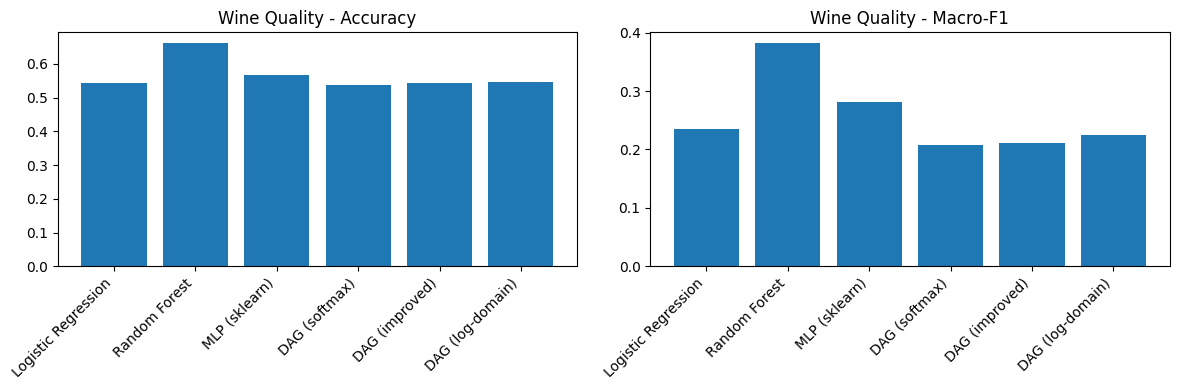

In [7]:
# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ==== 1. Load dataset (Wine Quality Kaggle) ====
df = pd.read_csv("/winequalityN.csv")

# one-hot encode type
if "type" in df.columns:
    df = pd.get_dummies(df, columns=["type"])

# drop NaN
df = df.dropna()

# split X, y
X = df.drop(columns=["quality"]).values
y_raw = df["quality"].values

# encode labels (3..9 -> 0..6)
le = LabelEncoder()
y = le.fit_transform(y_raw)
n_classes = len(np.unique(y))

print("Классы после энкодинга:", np.unique(y))  ]

# ==== 2. Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

# scale
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# torch tensors
X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)


# ==== 3. DAG models ====
class DAGClassifier(nn.Module):  # softmax
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        pi = F.softmax(r, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


class ImprovedDAGClassifier(nn.Module):  # softmax + gumbel
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8, temperature=0.7, use_gumbel=True):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))
        self.temperature = temperature
        self.use_gumbel = use_gumbel

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        if self.use_gumbel and self.training:
            pi = F.gumbel_softmax(r, tau=self.temperature, hard=False, dim=1)
        else:
            pi = F.softmax(r / self.temperature, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


class LogDomainDAGClassifier(nn.Module):  # log-softmax
    def __init__(self, n_features, n_classes, n_internal=8, n_leaves=6):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        log_pi = F.log_softmax(r, dim=1)
        logits = torch.einsum("bd,lcd->blc", x, self.leaf_theta) + self.leaf_bias
        log_pyl = F.log_softmax(logits, dim=-1)
        log_yhat = torch.logsumexp(log_pi[:, :, None] + log_pyl, dim=1)
        return log_yhat


# ==== 4. Training helper ====
def train_model(model, X_tr, y_tr, epochs=100, lr=5e-3, log_domain=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        if log_domain:
            log_y_hat = model(X_tr)
            loss = F.nll_loss(log_y_hat, y_tr)
        else:
            y_hat = model(X_tr)
            loss = F.cross_entropy(y_hat, y_tr)
        loss.backward()
        opt.step()
    return model


# ==== 5. Baselines + DAGs ====
results = []

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=seed).fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
results.append(["Logistic Regression", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=seed).fit(X_train_std, y_train)
y_pred = rf.predict(X_test_std)
results.append(["Random Forest", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed).fit(X_train_std, y_train)
y_pred = mlp.predict(X_test_std)
results.append(["MLP (sklearn)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# DAG (softmax)
torch.manual_seed(seed)
dag = DAGClassifier(X_train_t.shape[1], n_classes)
train_model(dag, X_train_t, y_train_t, epochs=100)
dag.eval()
with torch.no_grad():
    y_pred = dag(X_test_t).argmax(dim=1).numpy()
results.append(["DAG (softmax)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# DAG (improved)
torch.manual_seed(seed)
dag_imp = ImprovedDAGClassifier(X_train_t.shape[1], n_classes, temperature=0.7, use_gumbel=True)
train_model(dag_imp, X_train_t, y_train_t, epochs=100)
dag_imp.eval()
with torch.no_grad():
    y_pred = dag_imp(X_test_t).argmax(dim=1).numpy()
results.append(["DAG (improved)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# DAG (log-domain)
torch.manual_seed(seed)
dag_log = LogDomainDAGClassifier(X_train_t.shape[1], n_classes)
train_model(dag_log, X_train_t, y_train_t, epochs=100, log_domain=True)
dag_log.eval()
with torch.no_grad():
    y_pred = dag_log(X_test_t).argmax(dim=1).numpy()
results.append(["DAG (log-domain)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# ==== 6. Results table ====
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro-F1"])
print(df_results)

# ==== 7. Plot ====
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(df_results["Model"], df_results["Accuracy"])
axes[0].set_title("Wine Quality - Accuracy")
axes[0].set_xticklabels(df_results["Model"], rotation=45, ha="right")

axes[1].bar(df_results["Model"], df_results["Macro-F1"])
axes[1].set_title("Wine Quality - Macro-F1")
axes[1].set_xticklabels(df_results["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.show()

### Результаты на Wine Quality

- Метрики заметно ниже, чем в экспериментах на Iris/Wine/Digits: задача предсказания качества вина по химическим признакам более сложная.  
- **Random Forest** показал наилучший результат (Accuracy ≈ 0.66, Macro-F1 ≈ 0.38), уверенно превосходя остальные подходы.  
- **Logistic Regression** и **MLP** дали средние результаты, но всё ещё лучше, чем DAG-модели.  
- **DAG-классификаторы** в текущем виде показали схожие показатели, но слабее классических алгоритмов.  

**Вывод:**  
На датасете Wine Quality DAG-модели без дополнительной настройки уступают традиционным методам (особенно Random Forest). Это указывает на необходимость более тщательной настройки архитектуры и гиперпараметров для реальных, более шумных задач.  


Попробуем уменьшить количество классов и посмотреть как отработают модели на таких целевых переменных.
- Преобразуем метку качества вина из шкалы 3–9 в три укрупнённых класса:  
     - 0 = Low (качество ≤ 4)  
     - 1 = Medium (качество 5–6)  
     - 2 = High (качество ≥ 7).  

Классы: [0 1 2]  → 0=Low, 1=Medium, 2=High


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                 Model  Accuracy  Macro-F1
0  Logistic Regression  0.778236  0.433843
1        Random Forest  0.844765  0.580738
2        MLP (sklearn)  0.789582  0.536714
3        DAG (softmax)  0.782362  0.400422
4       DAG (improved)  0.779268  0.373761
5     DAG (log-domain)  0.794740  0.453293


/tmp/ipython-input-3199050915.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_results["Model"], rotation=45, ha="right")
/tmp/ipython-input-3199050915.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_results["Model"], rotation=45, ha="right")


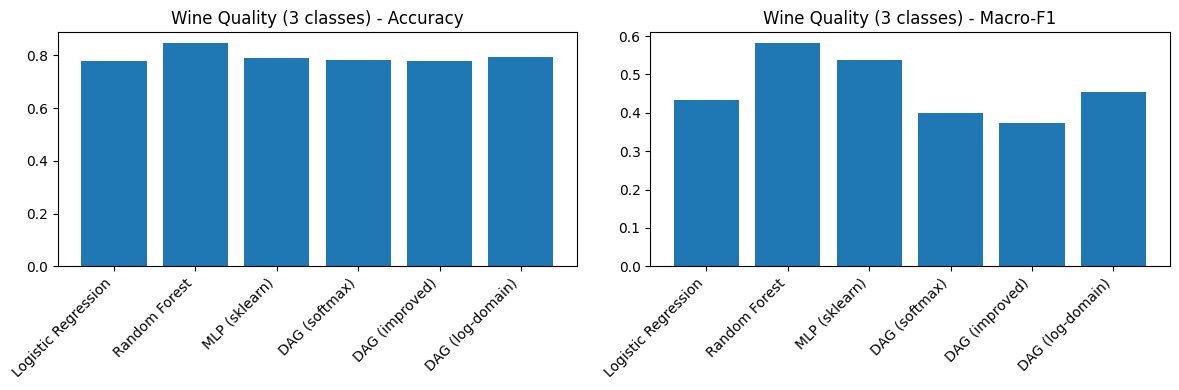

In [8]:

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ==== 1. Load dataset ====
df = pd.read_csv("/winequalityN.csv")  # Kaggle wine quality dataset

# one-hot encode type
if "type" in df.columns:
    df = pd.get_dummies(df, columns=["type"])

# drop NaN
df = df.dropna()

# ==== 2. Re-map quality into 3 classes ====
def map_quality(q):
    if q <= 4:
        return 0   # Low
    elif q <= 6:
        return 1   # Medium
    else:
        return 2   # High

df["quality"] = df["quality"].apply(map_quality)

X = df.drop(columns=["quality"]).values
y = df["quality"].values
n_classes = len(np.unique(y))

print("Классы:", np.unique(y), " → 0=Low, 1=Medium, 2=High")

# ==== 3. Split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# torch tensors
X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)


# ==== 4. DAG models ====
class DAGClassifier(nn.Module):  # softmax
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        pi = F.softmax(r, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


class ImprovedDAGClassifier(nn.Module):  # softmax + gumbel
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8, temperature=0.7, use_gumbel=True):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))
        self.temperature = temperature
        self.use_gumbel = use_gumbel

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        if self.use_gumbel and self.training:
            pi = F.gumbel_softmax(r, tau=self.temperature, hard=False, dim=1)
        else:
            pi = F.softmax(r / self.temperature, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


class LogDomainDAGClassifier(nn.Module):  # log-softmax
    def __init__(self, n_features, n_classes, n_internal=8, n_leaves=6):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        log_pi = F.log_softmax(r, dim=1)
        logits = torch.einsum("bd,lcd->blc", x, self.leaf_theta) + self.leaf_bias
        log_pyl = F.log_softmax(logits, dim=-1)
        log_yhat = torch.logsumexp(log_pi[:, :, None] + log_pyl, dim=1)
        return log_yhat


# ==== 5. Training helper ====
def train_model(model, X_tr, y_tr, epochs=100, lr=5e-3, log_domain=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        if log_domain:
            log_y_hat = model(X_tr)
            loss = F.nll_loss(log_y_hat, y_tr)
        else:
            y_hat = model(X_tr)
            loss = F.cross_entropy(y_hat, y_tr)
        loss.backward()
        opt.step()
    return model


# ==== 6. Baselines + DAGs ====
results = []

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=seed).fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
results.append(["Logistic Regression", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=seed).fit(X_train_std, y_train)
y_pred = rf.predict(X_test_std)
results.append(["Random Forest", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed).fit(X_train_std, y_train)
y_pred = mlp.predict(X_test_std)
results.append(["MLP (sklearn)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# DAG (softmax)
torch.manual_seed(seed)
dag = DAGClassifier(X_train_t.shape[1], n_classes)
train_model(dag, X_train_t, y_train_t, epochs=100)
dag.eval()
with torch.no_grad():
    y_pred = dag(X_test_t).argmax(dim=1).numpy()
results.append(["DAG (softmax)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# DAG (improved)
torch.manual_seed(seed)
dag_imp = ImprovedDAGClassifier(X_train_t.shape[1], n_classes, temperature=0.7, use_gumbel=True)
train_model(dag_imp, X_train_t, y_train_t, epochs=100)
dag_imp.eval()
with torch.no_grad():
    y_pred = dag_imp(X_test_t).argmax(dim=1).numpy()
results.append(["DAG (improved)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# DAG (log-domain)
torch.manual_seed(seed)
dag_log = LogDomainDAGClassifier(X_train_t.shape[1], n_classes)
train_model(dag_log, X_train_t, y_train_t, epochs=100, log_domain=True)
dag_log.eval()
with torch.no_grad():
    y_pred = dag_log(X_test_t).argmax(dim=1).numpy()
results.append(["DAG (log-domain)", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average="macro")])

# ==== 7. Results table ====
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro-F1"])
print(df_results)

# ==== 8. Plot ====
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(df_results["Model"], df_results["Accuracy"])
axes[0].set_title("Wine Quality (3 classes) - Accuracy")
axes[0].set_xticklabels(df_results["Model"], rotation=45, ha="right")

axes[1].bar(df_results["Model"], df_results["Macro-F1"])
axes[1].set_title("Wine Quality (3 classes) - Macro-F1")
axes[1].set_xticklabels(df_results["Model"], rotation=45, ha="right")

plt.tight_layout()
plt.show()


- **Random Forest** уверенно лидирует по обоим показателям (Accuracy ≈ 0.84, Macro-F1 ≈ 0.58).  
- **MLP** демонстрирует сбалансированные результаты (Accuracy ≈ 0.79, Macro-F1 ≈ 0.54), лучше, чем Logistic Regression.  
- **DAG-модели** показывают сравнимый уровень Accuracy (~0.78–0.79), но проигрывают по Macro-F1, что говорит о трудностях с балансом между классами.  
- **Log-domain DAG** оказался немного устойчивее и дал более высокий F1 по сравнению с softmax и improved вариантами.  

**Вывод:**  
Для задачи Wine Quality (3 класса) традиционные алгоритмы (Random Forest и MLP) пока превосходят DAG-классификаторы. Попробуем выполнить настройку гиперпараметров.

In [ ]:
#pip install optuna

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import optuna

С помощью Optuna будем настраивать следующие гиперпараметры:

- **`n_internal`** *(int)* — количество скрытых (внутренних) узлов в DAG (от 8 до 32).  
  Определяет размер промежуточного представления перед выходом на листья.  

- **`n_leaves`** *(int)* — количество листьев в DAG (от 4 до 20).  
  Чем больше листьев, тем богаче композиция "экспертов", но выше риск переобучения.  

- **`temperature`** *(float)* — параметр температуры (от 0.3 до 2.0).  
  Контролирует «остроту» распределения вероятностей по листьям:  
  - низкая температура → более жёсткий выбор,  
  - высокая → более равномерное распределение.  

- **`use_gumbel`** *(categorical: True/False)* — использовать ли **Gumbel-softmax** при обучении.  


In [9]:
# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ==== 1. Load dataset ====
df = pd.read_csv("/winequalityN.csv")  # Kaggle Wine Quality

# one-hot encode type
if "type" in df.columns:
    df = pd.get_dummies(df, columns=["type"])

# drop NaN
df = df.dropna()

# ==== 2. Re-map quality into 3 classes ====
def map_quality(q):
    if q <= 4:
        return 0   # Low
    elif q <= 6:
        return 1   # Medium
    else:
        return 2   # High

df["quality"] = df["quality"].apply(map_quality)

X = df.drop(columns=["quality"]).values
y = df["quality"].values
n_classes = len(np.unique(y))

# ==== 3. Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# Torch tensors
X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

# ==== 4. Class weights ====
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


# ==== 5. Improved DAG ====
class ImprovedDAGClassifier(nn.Module):
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8, temperature=0.7, use_gumbel=True):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))
        self.temperature = temperature
        self.use_gumbel = use_gumbel

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        if self.use_gumbel and self.training:
            pi = F.gumbel_softmax(r, tau=self.temperature, hard=False, dim=1)
        else:
            pi = F.softmax(r / self.temperature, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


# ==== 6. Training ====
def train_multiclass(model, X_tr, y_tr, class_weights, epochs=100, lr=5e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        y_hat = model(X_tr)
        loss = F.cross_entropy(y_hat, y_tr, weight=class_weights)
        loss.backward()
        opt.step()
    return model


# ==== 7. Optuna objective ====
def objective(trial):
    n_internal = trial.suggest_int("n_internal", 8, 32)
    n_leaves = trial.suggest_int("n_leaves", 4, 20)
    temperature = trial.suggest_float("temperature", 0.3, 2.0)
    use_gumbel = trial.suggest_categorical("use_gumbel", [True, False])

    model = ImprovedDAGClassifier(
        n_features=X_train_t.shape[1],
        n_classes=n_classes,
        n_internal=n_internal,
        n_leaves=n_leaves,
        temperature=temperature,
        use_gumbel=use_gumbel
    )

    train_multiclass(model, X_train_t, y_train_t, class_weights, epochs=100, lr=5e-3)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t).argmax(dim=1).cpu().numpy()

    return f1_score(y_test, y_pred, average="macro")


# ==== 8. Run Optuna ====
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_trial.params)
print("Best Macro-F1:", study.best_value)


# ==== 9. Retrain best model ====
best_params = study.best_trial.params
best_model = ImprovedDAGClassifier(
    n_features=X_train_t.shape[1],
    n_classes=n_classes,
    n_internal=best_params["n_internal"],
    n_leaves=best_params["n_leaves"],
    temperature=best_params["temperature"],
    use_gumbel=best_params["use_gumbel"]
)

train_multiclass(best_model, X_train_t, y_train_t, class_weights, epochs=150, lr=5e-3)

best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_test_t).argmax(dim=1).cpu().numpy()

print("\n==== Final Evaluation (Improved DAG + class weights) ====")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Macro-F1 :", f1_score(y_test, y_pred, average="macro"))

[I 2025-08-26 15:10:45,333] A new study created in memory with name: no-name-568aa2f7-5e63-4426-b58e-6ed80b3410a9
[I 2025-08-26 15:10:48,051] Trial 0 finished with value: 0.47263008585489724 and parameters: {'n_internal': 11, 'n_leaves': 17, 'temperature': 1.0930495303932672, 'use_gumbel': False}. Best is trial 0 with value: 0.47263008585489724.
[I 2025-08-26 15:10:49,876] Trial 1 finished with value: 0.46788069408502153 and parameters: {'n_internal': 24, 'n_leaves': 12, 'temperature': 1.098008955637598, 'use_gumbel': False}. Best is trial 0 with value: 0.47263008585489724.
[I 2025-08-26 15:10:51,102] Trial 2 finished with value: 0.4738593409667497 and parameters: {'n_internal': 32, 'n_leaves': 7, 'temperature': 0.8930334928863346, 'use_gumbel': False}. Best is trial 2 with value: 0.4738593409667497.
[I 2025-08-26 15:10:53,421] Trial 3 finished with value: 0.4404793757581149 and parameters: {'n_internal': 16, 'n_leaves': 12, 'temperature': 0.7705893066828816, 'use_gumbel': True}. Best 

Best params: {'n_internal': 21, 'n_leaves': 13, 'temperature': 0.4637784198679526, 'use_gumbel': False}
Best Macro-F1: 0.48543618805300826

==== Final Evaluation (Improved DAG + class weights) ====
Accuracy : 0.6157813305827746
Macro-F1 : 0.4980630483572395


- Подбор гиперпараметров и использование весов классов улучшило сбалансированность обучения, но качество всё ещё остаётся слабым.  
- Метрика Accuracy выше 0.6 указывает на то, что модель уловила часть закономерностей, однако **Macro-F1 < 0.5** говорит о том, что классы различаются неравномерно, и модель хуже справляется с менее представленными классами.  

Рассмотрим ансамбль из 5 моделей

In [10]:


# ==== Improved DAG ====
class ImprovedDAGClassifier(nn.Module):
    def __init__(self, n_features, n_classes, n_internal=16, n_leaves=8, temperature=0.7, use_gumbel=True):
        super().__init__()
        self.src_to_int = nn.Parameter(torch.randn(n_features, n_internal) * 0.1)
        self.int_to_leaf = nn.Parameter(torch.randn(n_internal, n_leaves) * 0.1)
        self.leaf_theta = nn.Parameter(torch.randn(n_leaves, n_classes, n_features) * 0.01)
        self.leaf_bias  = nn.Parameter(torch.zeros(n_leaves, n_classes))
        self.temperature = temperature
        self.use_gumbel = use_gumbel

    def forward(self, x):
        h_int = torch.matmul(x, self.src_to_int)
        r = torch.matmul(h_int, self.int_to_leaf)
        if self.use_gumbel and self.training:
            pi = F.gumbel_softmax(r, tau=self.temperature, hard=False, dim=1)
        else:
            pi = F.softmax(r / self.temperature, dim=1)
        leaf_logits = torch.einsum("bf,lcf->blc", x, self.leaf_theta) + self.leaf_bias
        leaf_probs  = F.softmax(leaf_logits, dim=-1)
        y_hat = torch.einsum("bl,blc->bc", pi, leaf_probs)
        return y_hat


# ==== Training helper ====
def train_multiclass(model, X_tr, y_tr, class_weights, epochs=100, lr=5e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        y_hat = model(X_tr)
        loss = F.cross_entropy(y_hat, y_tr, weight=class_weights)
        loss.backward()
        opt.step()
    return model


# ==== Ensemble DAG ====
def train_dag_ensemble(X_train_t, y_train_t, X_test_t, y_test, class_weights,
                       n_models=5, n_internal=16, n_leaves=12, temperature=0.7):
    preds = []
    for i in range(n_models):
        torch.manual_seed(42 + i)  # разные инициализации
        model = ImprovedDAGClassifier(
            n_features=X_train_t.shape[1],
            n_classes=len(torch.unique(y_train_t)),
            n_internal=n_internal,
            n_leaves=n_leaves,
            temperature=temperature,
            use_gumbel=True
        )
        train_multiclass(model, X_train_t, y_train_t, class_weights, epochs=100, lr=5e-3)
        model.eval()
        with torch.no_grad():
            y_prob = model(X_test_t).cpu().numpy()  # вероятности
        preds.append(y_prob)

    # усреднение вероятностей
    avg_preds = np.mean(preds, axis=0)
    y_pred = avg_preds.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    return acc, f1, y_pred

In [13]:

# посчитаем веса классов
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Ensemble DAG (например 5 моделей)
acc, f1, y_pred = train_dag_ensemble(
    X_train_t, y_train_t, X_test_t, y_test,
    class_weights,
    n_models=5, n_internal=16, n_leaves=12, temperature=0.7
)

print("==== Ensemble DAG (5 models) ====")
print("Accuracy :", acc)
print("Macro-F1 :", f1)

==== Ensemble DAG (5 models) ====
Accuracy : 0.5538937596699329
Macro-F1 : 0.4524624150164769


После усреднения предсказаний пяти обученных Improved DAG моделей:

- Ансамбль не привёл к росту качества: показатели даже ниже, чем у одной оптимизированной модели (Accuracy ≈ 0.616, Macro-F1 ≈ 0.498).  
- Это может указывать на то, что модели слишком похожи друг на друга (низкое разнообразие ансамбля), и усреднение сгладило полезные различия.  

Энсамблирование Improved DAG в лоб не дало выигрыша на задаче Wine Quality. Напрвления для улучшения:
- обучать модели с разными гиперпараметрами (bagging),  
- использовать бутстрэп-подвыборки данных,  
- комбинировать DAG с другими типами моделей (гибридный ансамбль).


## Результат эксперимента

В ходе экспериментов мы протестировали **DAG-классификаторы** (разные варианты: softmax, improved, log-domain) на нескольких датасетах:

- На **учебных наборах** (Iris, Wine, Digits) DAG-модели показали очень высокие результаты, сопоставимые и даже превосходящие классические алгоритмы (Logistic Regression, Random Forest, MLP). Это свидетельствует о том, что архитектура DAG хорошо улавливает структуру данных и может выступать как интерпретируемая альтернатива традиционным моделям.  

Однако:  

- На **реальном кейсе Wine Quality** DAG-модели показали результаты хуже по сравнению с Random Forest и MLP.  
- Несмотря на настройку гиперпараметров (Optuna) и попытку улучшить результаты ансамблированием, DAG-модели не смогли достичь качества лучших бейзлайнов.  

**Вывод:**  
- DAG-подходы перспективны и демонстрируют отличные результаты на простых и учебных датасетах.  
- Но для реальных, более шумных и сложных задач требуется дальнейшая доработка:  
  - усовершенствование архитектуры (например, глубина DAG, дополнительные регуляризации),  
  - более тщательный поиск гиперпараметров,  
  - комбинирование DAG с другими моделями в ансамблях.  


